## План работы
### 1. Подготовка данных
Проверка данных на наличие пропусков, проверка формата данных.
### 2. Исследование баланса классов
Применение техник апсэмплинга, даунсэмплинга и взвешивания классов для борьбы с дисбалансом.
### 3. Подбор гиперпараметров
Подбор гиперпараметров для оптимальной модели, выбранной на предыдущем шаге, с помощью кросс-валидации.
### 4. Тестирование модели
Проверка оптимальной модели на тестовой выборке. Проверка модели на адекватность.

## Данные
В наличии были следующие данные:
- личные данные клиента (фамилия, пол, возраст, страна проживания)
- кредитный рейтинг
- количество недвижимости у клиента
- баланс на счёте
- количество продуктов банка, используемых клиентом
- наличие кредитной карты
- активность клиента
- предполагаемая зарплата

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('../bank/Bank.csv')
display(data)
print(data.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


In [2]:
print(data['Geography'].value_counts())
print(len(data['Surname'].value_counts()))
data['Tenure'] = data['Tenure'].fillna(0)
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
2932


В столбце 'Tenure' присутствует много пропусков, заполним их нолями (вероятнее всего, отсутствие данных по количеству недвижисмости означает отсутствие недвижимости). Столбцы 'RowNumber','CustomerId' и 'Surname' не представляют интереса при расчёте вероятности оттока клиента. В столбце 'Geography' всего три возможных значения, следовательно, этот столбец можно учитывать при прогнозировании, предварительно обработав техникой прямого кодирования.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

features_trainvalid, features_test, target_trainvalid, target_test = train_test_split(features,target,test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_trainvalid,target_trainvalid,test_size=0.25, random_state=12345)

numeric = ['CreditScore','Age','Balance', 'Tenure', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_trainvalid[numeric] = scaler.transform(features_trainvalid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Обработаем данные техникой прямого кодирования. Разделим выборку на тестовую, тренировочную и валидационную в соотношении 1 к 3 к 1. Стандартизируем данные в столбцах 'CreditScore', 'Age', 'Balance', 'Tenure', 'NumOfProducts' и 'EstimatedSalary' с помощью структуры StandardScaler.

# 2. Исследование баланса классов

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print(data['Exited'].value_counts())
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("Accuracy для модели логистической регрессии равна", accuracy_score(target_valid,predicted_valid),
      ", F1 равно {:.2f}".format(f1_score(target_valid, predicted_valid)),
      ", AUC-ROC равно {:.2f}".format(auc_roc))

target_predicted_constant = pd.Series([0]*len(data))
print("Accuracy для константной модели равна", accuracy_score(target,target_predicted_constant))

0    7963
1    2037
Name: Exited, dtype: int64
Accuracy для модели логистической регрессии равна 0.816 , F1 равно 0.31 , AUC-ROC равно 0.77
Accuracy для константной модели равна 0.7963


Класс 0 встречается примерно в 80% случаев, класс 1 - в 20%. Создадим модель логистической регрессии, обучим её на тренировочной выборке и протестируем на валидационной. Получим значение F1-меры 0.31 и AUC-ROC 0.77. Затем сравним её эффективность с константной моделью (которая будет всегда предсказывать наиболее частотный класс 0), используя метрику accuracy. Получим, что отличие обученной модели от константной практически отсутствует. Это означает, что может быть необходимо учесть дисбаланс классов.

Логистическая регрессия, взвешивание классов
F1 равно 0.48 , AUC-ROC равно 0.77


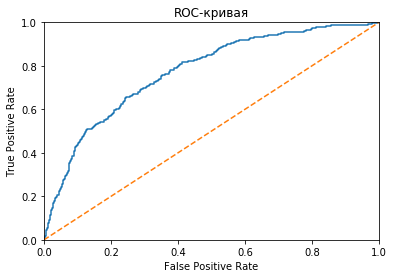

In [5]:
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
metrics_lr=[] 
metrics_dt=[]

def show_metrics(model):
    """
    Выводит на экран F1-меру, ROC-AUC и график ROC-кривой
    """
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities = model.predict_proba(features_test)[:, 1]
    f1score = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_test,probabilities)
    
    
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    return f1score, auc_roc

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
print("Логистическая регрессия, взвешивание классов")
f1score, auc_roc = show_metrics(model)
metrics_lr.append([f1score, auc_roc])

print("F1 равно {:.2f}".format(f1score),
      ", AUC-ROC равно {:.2f}".format(auc_roc))

Дерево решений, взвешивание классов
F1 равно 0.55 , AUC-ROC равно 0.82


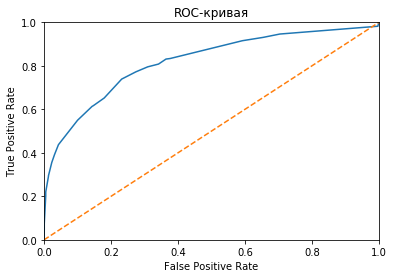

In [6]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
f1score, auc_roc = show_metrics(model)
metrics_dt.append([f1score, auc_roc])
print("Дерево решений, взвешивание классов")
print("F1 равно {:.2f}".format(f1score),
      ", AUC-ROC равно {:.2f}".format(auc_roc))

Опробуем несколько способов борьбы с дисбалансом на моделях логистической регрессии и дерева решений. Если проводить взвешивание классов, то для логистической регрессии значение F1-меры составляет 0.48, для дерева решений - 0.55. Отметим, что значение метрики AUC-ROC довольно близко к единице во втором случае. Тем не менее, так как классы сильно несбалансированы, ROC-AUC может давать неадекватные результаты. По этой причине F1-меру использовать предпочтительнее.

In [7]:
from sklearn.utils import shuffle
def upsample(features, target, repeat):
    """
    функция для реализации апсэмплинга
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1score=f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

metrics_lr.append([f1score, auc_roc])
print("Логистическая регрессия, апсэмплинг")
print("F1 равно {:.2f}".format(f1score),
      ", AUC-ROC равно {:.2f}".format(auc_roc))

Логистическая регрессия, апсэмплинг
F1 равно 0.48 , AUC-ROC равно 0.77


In [8]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

f1score=f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

metrics_dt.append([f1score, auc_roc])
print("Дерево решений, апсэмплинг")
print("F1 равно {:.2f}".format(f1score),
      ", AUC-ROC равно {:.2f}".format(auc_roc))

Дерево решений, апсэмплинг
F1 равно 0.55 , AUC-ROC равно 0.82


Реализуем апсэмплинг с помощью функции upsample, увеличив количество объектов класса 1 в 4 раза (так как соотношение классов 0 и 1 примерно 4:1). Полученные значения f1-меры не отличаются от тех, что были получены при взвешивании классов.

In [9]:
def downsample(features, target, fraction):
    """
    функция для реализации даунсэмплинга
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
f1score=f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

metrics_lr.append([f1score, auc_roc])
print("Логистическая регрессия, даунсэмплинг")
print("F1 равно {:.2f}".format(f1score),
      ", AUC-ROC равно {:.2f}".format(auc_roc))

Логистическая регрессия, даунсэмплинг
F1 равно 0.49 , AUC-ROC равно 0.77


In [10]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
f1score=f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

metrics_dt.append([f1score, auc_roc])
print("Дерево решений, даунсэмплинг")
print("F1 равно {:.2f}".format(f1score),
      ", AUC-ROC равно {:.2f}".format(auc_roc))

Дерево решений, даунсэмплинг
F1 равно 0.56 , AUC-ROC равно 0.83


Реализуем апсэмплинг с помощью функции downsample, взяв 75 % данных класса 0. В этом случае немного возрастает значение f1-меры как для логистической регрессии, так и для дерева решений.

In [11]:
metrics_lr1 = pd.DataFrame(metrics_lr)
metrics_dt1 = pd.DataFrame(metrics_dt)
metrics = pd.concat((metrics_lr1, metrics_dt1), axis = 1)
metrics.columns =['f1 для LR','auc-roc для LR','f1 для DT','auc-roc для DT']
metrics.index = ["Взвешивание","Upsampling","Downsampling"]
display(metrics)

,f1 для LR,auc-roc для LR,f1 для DT,auc-roc для DT
Взвешивание,0.477639,0.772963,0.548908,0.818801
Upsampling,0.479222,0.772957,0.548908,0.818801
Downsampling,0.488327,0.773401,0.556818,0.828581


Модель логистической регрессии во всех случаях показывала худшие результаты, чем дерево решений. Однако все техники борьбы с дисбалансом дали увеличение f1-меры по сравнению с моделью, натренированной на несбалансированных данных. Лучшие результаты (f1-мера 0.56) показала модель дерева решений на данных, к которым предварительно была применён даунсэмплинг.

## Вывод

Были исследованы разные техники борьбы с дисбалансом на моделях логистической регрессии и дерева решений. Во всех случаях дерево решений показывало более высокие значения f1-меры, лучший результат (f1-мера 0.56) был получен на данных, к которым был предварительно применён даунсэмплинг.

## 3. Подбор гиперпараметров

In [12]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

def rf_cross_validation(f_data, t_data, n, depth, estimators):
    """
    функция для определения лучших параметров случайного леса
    с помощью кросс-валидации,принимает на вход признаки,
    целевые признаки и число фолдов, возвращает максимальное
    значение f1-меры и оптимальные параметры (max_depth,n_estimators)
    """
    kf = KFold(n_splits=n, random_state=12345, shuffle=True)
    array=[]
    f_data=f_data.reset_index(drop=True)
    t_data=t_data.reset_index(drop=True)
    model = RandomForestClassifier(max_depth=depth, n_estimators=estimators, random_state=12345)
    
    for train_index, test_index in kf.split(t_data):
        f_train, f_valid = f_data.loc[train_index], f_data.loc[test_index] #признаки
        t_train, t_valid = t_data.loc[train_index], t_data.loc[test_index] #целевые признаки
        f_train, t_train = downsample(f_train, t_train, 0.3)
    
        model.fit(f_train, t_train)
        pr_valid = model.predict(f_valid)
        f1score = f1_score(t_valid, pr_valid)
        array.append(f1score)
    
    return sum(array)/len(array)

f1_array=[]
parameters=[]

for depth in range(3,14):
    for estimators in range(10,51,10):
        f1score = rf_cross_validation(features_trainvalid, target_trainvalid, 5, depth, estimators)
        f1_array.append(f1score)
        parameters.append((depth, estimators))

f1_final = max(f1_array)
parameters_final = parameters[f1_array.index(max(f1_array))]
        
print("Для модели случайного леса с max_depth =", parameters_final[0],
     "и n_estimators =", parameters_final[1], "значение f1-меры равно {:.2f}".format(f1_final))

Для модели случайного леса с max_depth = 8 и n_estimators = 40 значение f1-меры равно 0.59


Так как модель случайного леса в общем случае показывает лучшие результаты, чем модель дерева решений, можно попробовать подобрать лучшие параметры для модели случайного леса. Реализуем это с помощью функции rf_cross_validation, в которой обучающая выборка каждый раз обрабатывается даунсэмплингом, а параметры случайного леса max_depth и n_estimators перебираются в циклах. Лучшие результаты показывает модель с максимальной глубиной 8 и числом деревьев 40.

# 4. Тестирование модели

F1 равно 0.62 , AUC-ROC равно 0.87


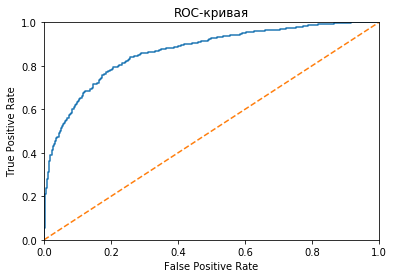

In [13]:
features_downsampled, target_downsampled = downsample(features_trainvalid, target_trainvalid, 0.3)

model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=8)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print("F1 равно {:.2f}".format(f1_score(target_test, predicted_test)),
      ", AUC-ROC равно {:.2f}".format(roc_auc_score(target_test, probabilities_one_test)))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')

На тестовой выборке получилось достичь и превысить заданное значение f1-меры. Отметим, что хотя значение AUC-ROC по сравнению с моделью дерева решений со сбалансированными классами изменилось не сильно (0.87 против 0.82 ранее), ROC-кривая стала более крутой, что показывает, что эта модель в большей степени подходит для прогноза.

## Вывод

Проведено исследование различных способов борьбы с дисбалансом. Оптимальным для данной выборки является даунсэмплинг (использование 30% данных класса 0). Лучшие результаты показывает модель случайного леса с 40 деревьями и максимальной глубиной 8. Используя эту модель, на тестовой выборке получилось достичь значение f1-меры, равное 0.62.